# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

---

In this notebook, we use transfer learning to train a CNN to classify dog breeds.

### 1. Load Dog Dataset

Before running the code cell below, download the dataset of dog images [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip) and place it in the respository.

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load ordered list of dog names
dog_names = [item[25:-1] for item in glob('dogImages/train/*/')]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % str(len(train_files) + len(valid_files) + len(test_files)))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### 2. Visualize the First 12 Training Images

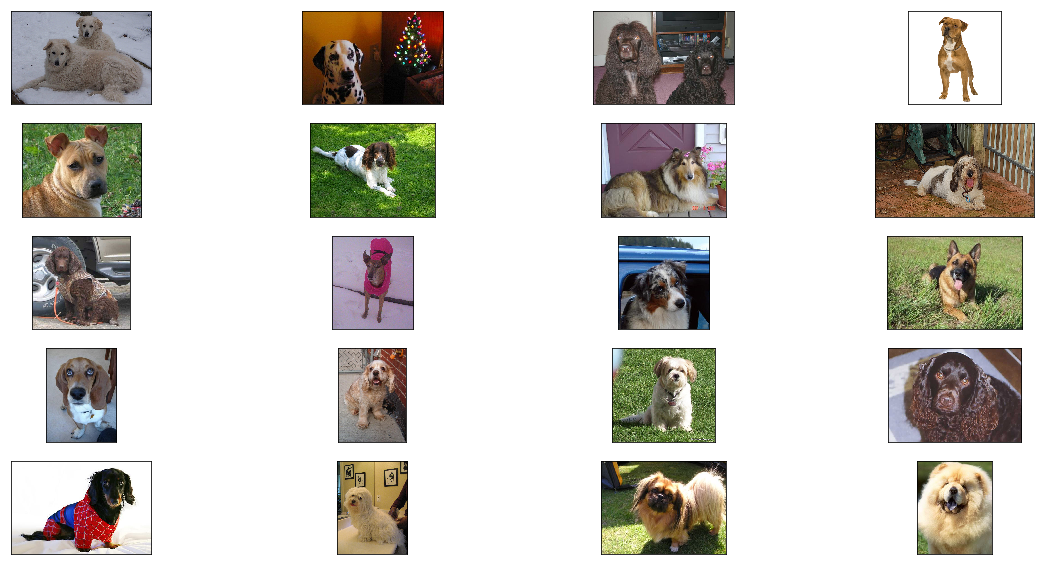

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(20, 10))
for i in range(20):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    visualize_img(train_files[i], ax)

### 3. Obtain the VGG-16 Bottleneck Features

Before running the code cell below, download the file linked [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz) and place it in the `bottleneck_features/` folder.

In [3]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_vgg16 = bottleneck_features['train']
valid_vgg16 = bottleneck_features['valid']
test_vgg16 = bottleneck_features['test']

### 4. Define a Model Architecture (Model 1)

In [4]:
from keras.layers import Dense, Flatten
from keras.models import Sequential

model = Sequential()
model.add(Flatten(input_shape=(7, 7, 512)))
model.add(Dense(133, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               3336837   
Total params: 3,336,837.0
Trainable params: 3,336,837.0
Non-trainable params: 0.0
_________________________________________________________________


### 5. Define another Model Architecture (Model 2)

In [5]:
from keras.layers import GlobalAveragePooling2D

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(7, 7, 512)))
model.add(Dense(133, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### 6. Compile the Model (Model 2)

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

### 7. Train the Model (Model 2)

In [8]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='dogvgg16.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit(train_vgg16, train_targets, epochs=20, validation_data=(valid_vgg16, valid_targets), 
          callbacks=[checkpointer], verbose=1, shuffle=True)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s - loss: 12.6086 - acc: 0.1024 - val_loss: 10.8116 - val_acc: 0.2144
Epoch 2/20
6680/6680 [==============================] - 2s - loss: 10.1658 - acc: 0.2710 - val_loss: 10.0851 - val_acc: 0.2826
Epoch 3/20
6680/6680 [==============================] - 2s - loss: 9.5571 - acc: 0.3418 - val_loss: 9.7069 - val_acc: 0.3138
Epoch 4/20
6680/6680 [==============================] - 2s - loss: 9.2880 - acc: 0.3753 - val_loss: 9.6849 - val_acc: 0.3222
Epoch 5/20
6680/6680 [==============================] - 2s - loss: 9.1423 - acc: 0.4013 - val_loss: 9.5028 - val_acc: 0.3401
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 8.9749 - acc: 0.4171 - val_loss: 9.4884 - val_acc: 0.3437
Epoch 7/20
6680/6680 [==============================] - 2s - loss: 8.9251 - acc: 0.4295 - val_loss: 9.4051 - val_acc: 0.3449
Epoch 8/20
6680/6680 [==============================] - 2s - loss: 8.8974 

### 8. Load the Model with the Best Validation Accuracy (Model 2)

In [9]:
# load the weights that yielded the best validation accuracy
model.load_weights('dogvgg16.weights.best.hdf5')

### 9. Calculate Classification Accuracy on Test Set (Model 2)

In [10]:
# get index of predicted dog breed for each image in test set
vgg16_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) 
                     for feature in test_vgg16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(vgg16_predictions)==
                           np.argmax(test_targets, axis=1))/len(vgg16_predictions)
print('\nTest accuracy: %.4f%%' % test_accuracy)


Test accuracy: 44.8565%
